# Method 3 - Best Minus Rest Fresh Ideas

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Returns for Fresh Ideas

%store -r r

# Get Adjusted Quantities

qty_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='quantity',
                           aggfunc='sum')
qty_pivot = qty_pivot.mul(r.splits.reindex(qty_pivot.index), level=1).fillna(0)
qty_pivot = qty_pivot - qty_pivot.shift(1)
flat_qty = pd.melt(qty_pivot.reset_index(), id_vars='datadate', value_name='qty_change')
flat_qty = flat_qty[flat_qty['qty_change'] > 0]

# Get Pos Size Change

pos_size_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='target',
                                aggfunc='sum')
pos_size_pivot = pos_size_pivot - pos_size_pivot.shift(1)
flat_pos_size = pd.melt(pos_size_pivot.reset_index(), id_vars='datadate', value_name='size_change')
flat_pos_size = flat_pos_size[flat_pos_size['size_change'] > 0]

# Calculate Intra-Portfolio Cap Weight

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Calculate Intra-Portfolio Cap Weight Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

# Get Managers with Best Fresh Ideas

fresh_idea_mgrs = valid_data.merge(flat_qty).merge(flat_pos_size)
fresh_idea_mgrs = fresh_idea_mgrs[fresh_idea_mgrs['pos_rank'] == 1][['datadate', 'institution_id']].drop_duplicates()
fresh_idea_mgrs['fresh'] = 1

# Split Long and Short and Filter to Highest Tilts

long_ideas = valid_data[valid_data['pos_rank'] == 1].copy()
long_ideas = long_ideas.merge(fresh_idea_mgrs, on=['datadate', 'institution_id'], how='inner')
                                                                                         
short_ideas = valid_data[valid_data['pos_rank'] != 1].copy()
short_ideas = short_ideas.merge(fresh_idea_mgrs, on=['datadate', 'institution_id'], how='inner')

# Weight the best ideas equally

long_ideas['target'] = 1 / long_ideas.groupby('datadate')[
    'institution_id'].transform('count')

short_ideas['target'] = - short_ideas['target'] / short_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / short_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

best_ideas = pd.concat([long_ideas, short_ideas])

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

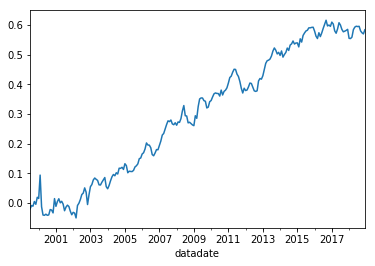

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.019354
2000-12-31   -0.004449
2001-12-31   -0.053676
2002-12-31    0.069968
2003-12-31    0.026892
2004-12-31    0.054968
2005-12-31    0.034703
2006-12-31    0.024067
2007-12-31    0.077361
2008-12-31   -0.005747
2009-12-31    0.061944
2010-12-31    0.034827
2011-12-31   -0.000894
2012-12-31    0.022067
2013-12-31    0.063816
2014-12-31    0.020820
2015-12-31    0.034582
2016-12-31    0.001881
2017-12-31   -0.006328
2018-12-31   -0.000900
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     14.03
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.97e-10
Time:                        13:08:24   Log-Likelihood:                 688.77
No. Observations:                 234   AIC:                            -1368.
Df Residuals:                     229   BIC:                            -1350.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.824      0.070      -0.000       0.003
mktrf         -0.0634      0.024     -2.640      0.009      -0.111      -0.016
me             0.1971      0.028      7.049      0.000       0.142       0.252
ia            -0.0906      0.042     -2.133      0.034      -0.174      -0.007
roe            0.0369      0.036      1.015      0.311      -0.035       0.109
==============================================================================
Omnibus:                       45.800   Durbin-Watson:                   2.132
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              179.557
Skew:                          -0.716   Prob(JB):                     1.02e-39
Kurtosis:                       7.045   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     3.858
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00470
Time:                        13:08:24   Log-Likelihood:                 688.77
No. Observations:                 234   AIC:                            -1368.
Df Residuals:                     229   BIC:                            -1350.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.921      0.055   -3.27e-05       0.003
mktrf         -0.0634      0.036     -1.778      0.075      -0.133       0.006
me             0.1971      0.059      3.321      0.001       0.081       0.313
ia            -0.0906      0.074     -1.218      0.223      -0.236       0.055
roe            0.0369      0.064      0.581      0.561      -0.088       0.161
==============================================================================
Omnibus:                       45.800   Durbin-Watson:                   2.132
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              179.557
Skew:                          -0.716   Prob(JB):                     1.02e-39
Kurtosis:                       7.045   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     3.422
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00968
Time:                        13:08:24   Log-Likelihood:                 688.77
No. Observations:                 234   AIC:                            -1368.
Df Residuals:                     229   BIC:                            -1350.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.874      0.061   -7.32e-05       0.003
mktrf         -0.0634      0.028     -2.302      0.021      -0.117      -0.009
me             0.1971      0.059      3.342      0.001       0.081       0.313
ia            -0.0906      0.072     -1.255      0.209      -0.232       0.051
roe            0.0369      0.062      0.594      0.552      -0.085       0.159
==============================================================================
Omnibus:                       45.800   Durbin-Watson:                   2.132
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              179.557
Skew:                          -0.716   Prob(JB):                     1.02e-39
Kurtosis:                       7.045   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     10.23
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.32e-09
Time:                        13:08:24   Log-Likelihood:                 686.81
No. Observations:                 234   AIC:                            -1362.
Df Residuals:                     228   BIC:                            -1341.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      2.311      0.022       0.000       0.004
mktrf         -0.0812      0.024     -3.338      0.001      -0.129      -0.033
smb            0.1716      0.032      5.345      0.000       0.108       0.235
hml           -0.0371      0.038     -0.979      0.329      -0.112       0.038
rmw           -0.0369      0.043     -0.861      0.390      -0.121       0.047
cma           -0.0002      0.054     -0.004      0.997      -0.107       0.107
==============================================================================
Omnibus:                       36.917   Durbin-Watson:                   2.182
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.562
Skew:                          -0.580   Prob(JB):                     4.46e-29
Kurtosis:                       6.471   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     2.769
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0189
Time:                        13:08:24   Log-Likelihood:                 686.81
No. Observations:                 234   AIC:                            -1362.
Df Residuals:                     228   BIC:                            -1341.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      2.759      0.006       0.001       0.004
mktrf         -0.0812      0.036     -2.258      0.024      -0.152      -0.011
smb            0.1716      0.051      3.387      0.001       0.072       0.271
hml           -0.0371      0.044     -0.840      0.401      -0.124       0.049
rmw           -0.0369      0.084     -0.440      0.660      -0.201       0.127
cma           -0.0002      0.111     -0.002      0.999      -0.218       0.218
==============================================================================
Omnibus:                       36.917   Durbin-Watson:                   2.182
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.562
Skew:                          -0.580   Prob(JB):                     4.46e-29
Kurtosis:                       6.471   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     3.914
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00201
Time:                        13:08:24   Log-Likelihood:                 686.81
No. Observations:                 234   AIC:                            -1362.
Df Residuals:                     228   BIC:                            -1341.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      3.076      0.002       0.001       0.003
mktrf         -0.0812      0.037     -2.216      0.027      -0.153      -0.009
smb            0.1716      0.041      4.139      0.000       0.090       0.253
hml           -0.0371      0.038     -0.965      0.335      -0.112       0.038
rmw           -0.0369      0.093     -0.396      0.692      -0.219       0.145
cma           -0.0002      0.124     -0.002      0.999      -0.244       0.244
==============================================================================
Omnibus:                       36.917   Durbin-Watson:                   2.182
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.562
Skew:                          -0.580   Prob(JB):                     4.46e-29
Kurtosis:                       6.471   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     20.79
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.23e-14
Time:                        13:08:24   Log-Likelihood:                 699.37
No. Observations:                 234   AIC:                            -1389.
Df Residuals:                     229   BIC:                            -1371.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.626      0.105      -0.000       0.003
mktrf         -0.0241      0.021     -1.141      0.255      -0.066       0.018
smb            0.1431      0.026      5.420      0.000       0.091       0.195
hml            0.0069      0.026      0.262      0.793      -0.045       0.059
umd            0.0909      0.017      5.281      0.000       0.057       0.125
==============================================================================
Omnibus:                       42.164   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              263.495
Skew:                          -0.460   Prob(JB):                     6.06e-58
Kurtosis:                       8.116   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     6.019
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000127
Time:                        13:08:24   Log-Likelihood:                 699.37
No. Observations:                 234   AIC:                            -1389.
Df Residuals:                     229   BIC:                            -1371.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.470      0.142      -0.000       0.003
mktrf         -0.0241      0.026     -0.943      0.346      -0.074       0.026
smb            0.1431      0.053      2.697      0.007       0.039       0.247
hml            0.0069      0.024      0.289      0.773      -0.040       0.054
umd            0.0909      0.035      2.623      0.009       0.023       0.159
==============================================================================
Omnibus:                       42.164   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              263.495
Skew:                          -0.460   Prob(JB):                     6.06e-58
Kurtosis:                       8.116   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     5.258
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000454
Time:                        13:08:24   Log-Likelihood:                 699.37
No. Observations:                 234   AIC:                            -1389.
Df Residuals:                     229   BIC:                            -1371.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.534      0.125      -0.000       0.003
mktrf         -0.0241      0.020     -1.206      0.228      -0.063       0.015
smb            0.1431      0.044      3.282      0.001       0.058       0.229
hml            0.0069      0.018      0.383      0.702      -0.028       0.042
umd            0.0909      0.034      2.661      0.008       0.024       0.158
==============================================================================
Omnibus:                       42.164   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              263.495
Skew:                          -0.460   Prob(JB):                     6.06e-58
Kurtosis:                       8.116   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     10.52
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.67e-07
Time:                        13:08:24   Log-Likelihood:                 330.05
No. Observations:                 120   AIC:                            -650.1
Df Residuals:                     115   BIC:                            -636.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.599      0.550      -0.002       0.004
mktrf         -0.0579      0.041     -1.422      0.158      -0.139       0.023
me             0.2411      0.040      5.996      0.000       0.161       0.321
ia            -0.1406      0.063     -2.233      0.027      -0.265      -0.016
roe            0.0944      0.056      1.694      0.093      -0.016       0.205
==============================================================================
Omnibus:                       20.335   Durbin-Watson:                   2.164
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.969
Skew:                          -0.689   Prob(JB):                     1.27e-09
Kurtosis:                       5.509   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     8.465
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.06e-06
Time:                        13:08:24   Log-Likelihood:                 330.05
No. Observations:                 120   AIC:                            -650.1
Df Residuals:                     115   BIC:                            -636.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.569      0.570      -0.002       0.004
mktrf         -0.0579      0.057     -1.024      0.306      -0.169       0.053
me             0.2411      0.064      3.760      0.000       0.115       0.367
ia            -0.1406      0.094     -1.488      0.137      -0.326       0.045
roe            0.0944      0.080      1.180      0.238      -0.062       0.251
==============================================================================
Omnibus:                       20.335   Durbin-Watson:                   2.164
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.969
Skew:                          -0.689   Prob(JB):                     1.27e-09
Kurtosis:                       5.509   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     9.059
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.13e-06
Time:                        13:08:24   Log-Likelihood:                 330.05
No. Observations:                 120   AIC:                            -650.1
Df Residuals:                     115   BIC:                            -636.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.534      0.593      -0.002       0.004
mktrf         -0.0579      0.042     -1.395      0.163      -0.139       0.023
me             0.2411      0.065      3.711      0.000       0.114       0.368
ia            -0.1406      0.094     -1.488      0.137      -0.326       0.045
roe            0.0944      0.067      1.410      0.158      -0.037       0.226
==============================================================================
Omnibus:                       20.335   Durbin-Watson:                   2.164
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.969
Skew:                          -0.689   Prob(JB):                     1.27e-09
Kurtosis:                       5.509   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     6.563
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.11e-05
Time:                        13:08:24   Log-Likelihood:                 326.51
No. Observations:                 120   AIC:                            -641.0
Df Residuals:                     114   BIC:                            -624.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.002      0.985      0.327      -0.002       0.005
mktrf         -0.0997      0.044     -2.246      0.027      -0.188      -0.012
smb            0.2116      0.050      4.208      0.000       0.112       0.311
hml           -0.0515      0.062     -0.835      0.405      -0.174       0.071
rmw           -0.0009      0.073     -0.012      0.991      -0.145       0.143
cma           -0.0309      0.080     -0.388      0.699      -0.189       0.127
==============================================================================
Omnibus:                       12.448   Durbin-Watson:                   2.271
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               19.526
Skew:                          -0.486   Prob(JB):                     5.75e-05
Kurtosis:                       4.720   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     2.949
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0153
Time:                        13:08:25   Log-Likelihood:                 326.51
No. Observations:                 120   AIC:                            -641.0
Df Residuals:                     114   BIC:                            -624.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.187      0.235      -0.001       0.004
mktrf         -0.0997      0.067     -1.498      0.134      -0.230       0.031
smb            0.2116      0.065      3.241      0.001       0.084       0.340
hml           -0.0515      0.060     -0.865      0.387      -0.168       0.065
rmw           -0.0009      0.122     -0.007      0.994      -0.240       0.238
cma           -0.0309      0.133     -0.233      0.816      -0.291       0.229
==============================================================================
Omnibus:                       12.448   Durbin-Watson:                   2.271
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               19.526
Skew:                          -0.486   Prob(JB):                     5.75e-05
Kurtosis:                       4.720   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     4.899
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000426
Time:                        13:08:25   Log-Likelihood:                 326.51
No. Observations:                 120   AIC:                            -641.0
Df Residuals:                     114   BIC:                            -624.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.280      0.200      -0.001       0.004
mktrf         -0.0997      0.070     -1.421      0.155      -0.237       0.038
smb            0.2116      0.054      3.930      0.000       0.106       0.317
hml           -0.0515      0.054     -0.957      0.339      -0.157       0.054
rmw           -0.0009      0.139     -0.006      0.995      -0.273       0.271
cma           -0.0309      0.146     -0.211      0.833      -0.318       0.256
==============================================================================
Omnibus:                       12.448   Durbin-Watson:                   2.271
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               19.526
Skew:                          -0.486   Prob(JB):                     5.75e-05
Kurtosis:                       4.720   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     12.50
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.78e-08
Time:                        13:08:25   Log-Likelihood:                 333.00
No. Observations:                 120   AIC:                            -656.0
Df Residuals:                     115   BIC:                            -642.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      0.886      0.377      -0.002       0.004
mktrf         -0.0267      0.035     -0.764      0.447      -0.096       0.043
smb            0.1510      0.040      3.789      0.000       0.072       0.230
hml           -0.0049      0.040     -0.124      0.902      -0.084       0.074
umd            0.0945      0.025      3.843      0.000       0.046       0.143
==============================================================================
Omnibus:                       17.431   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.863
Skew:                          -0.384   Prob(JB):                     2.01e-12
Kurtosis:                       6.191   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     5.101
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000806
Time:                        13:08:25   Log-Likelihood:                 333.00
No. Observations:                 120   AIC:                            -656.0
Df Residuals:                     115   BIC:                            -642.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.774      0.439      -0.002       0.005
mktrf         -0.0267      0.042     -0.638      0.523      -0.109       0.055
smb            0.1510      0.068      2.208      0.027       0.017       0.285
hml           -0.0049      0.032     -0.155      0.877      -0.067       0.058
umd            0.0945      0.043      2.180      0.029       0.010       0.180
==============================================================================
Omnibus:                       17.431   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.863
Skew:                          -0.384   Prob(JB):                     2.01e-12
Kurtosis:                       6.191   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     5.542
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000408
Time:                        13:08:25   Log-Likelihood:                 333.00
No. Observations:                 120   AIC:                            -656.0
Df Residuals:                     115   BIC:                            -642.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.792      0.428      -0.002       0.004
mktrf         -0.0267      0.033     -0.812      0.417      -0.091       0.038
smb            0.1510      0.056      2.686      0.007       0.041       0.261
hml           -0.0049      0.027     -0.183      0.855      -0.058       0.048
umd            0.0945      0.040      2.347      0.019       0.016       0.173
==============================================================================
Omnibus:                       17.431   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.863
Skew:                          -0.384   Prob(JB):                     2.01e-12
Kurtosis:                       6.191   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     2.539
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0440
Time:                        13:08:25   Log-Likelihood:                 388.07
No. Observations:                 114   AIC:                            -766.1
Df Residuals:                     109   BIC:                            -752.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.393      0.018       0.000       0.004
mktrf         -0.0384      0.024     -1.588      0.115      -0.086       0.010
me             0.0607      0.037      1.626      0.107      -0.013       0.135
ia            -0.0064      0.052     -0.124      0.902      -0.109       0.096
roe           -0.1007      0.046     -2.213      0.029      -0.191      -0.011
==============================================================================
Omnibus:                        1.568   Durbin-Watson:                   1.802
Prob(Omnibus):                  0.457   Jarque-Bera (JB):                1.263
Skew:                           0.015   Prob(JB):                        0.532
Kurtosis:                       2.485   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     5.357
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000563
Time:                        13:08:25   Log-Likelihood:                 388.07
No. Observations:                 114   AIC:                            -766.1
Df Residuals:                     109   BIC:                            -752.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.734      0.006       0.001       0.003
mktrf         -0.0384      0.018     -2.156      0.031      -0.073      -0.003
me             0.0607      0.038      1.595      0.111      -0.014       0.135
ia            -0.0064      0.053     -0.120      0.904      -0.111       0.098
roe           -0.1007      0.052     -1.942      0.052      -0.202       0.001
==============================================================================
Omnibus:                        1.568   Durbin-Watson:                   1.802
Prob(Omnibus):                  0.457   Jarque-Bera (JB):                1.263
Skew:                           0.015   Prob(JB):                        0.532
Kurtosis:                       2.485   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     9.625
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.05e-06
Time:                        13:08:25   Log-Likelihood:                 388.07
No. Observations:                 114   AIC:                            -766.1
Df Residuals:                     109   BIC:                            -752.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.281      0.001       0.001       0.003
mktrf         -0.0384      0.014     -2.667      0.008      -0.067      -0.010
me             0.0607      0.032      1.913      0.056      -0.001       0.123
ia            -0.0064      0.056     -0.114      0.910      -0.117       0.104
roe           -0.1007      0.047     -2.121      0.034      -0.194      -0.008
==============================================================================
Omnibus:                        1.568   Durbin-Watson:                   1.802
Prob(Omnibus):                  0.457   Jarque-Bera (JB):                1.263
Skew:                           0.015   Prob(JB):                        0.532
Kurtosis:                       2.485   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     2.961
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0152
Time:                        13:08:25   Log-Likelihood:                 390.32
No. Observations:                 114   AIC:                            -768.6
Df Residuals:                     108   BIC:                            -752.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.377      0.019       0.000       0.004
mktrf         -0.0381      0.023     -1.678      0.096      -0.083       0.007
smb            0.0688      0.037      1.865      0.065      -0.004       0.142
hml           -0.0374      0.047     -0.794      0.429      -0.131       0.056
rmw           -0.1452      0.058     -2.521      0.013      -0.259      -0.031
cma            0.0540      0.073      0.739      0.461      -0.091       0.199
==============================================================================
Omnibus:                        1.892   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.388   Jarque-Bera (JB):                1.534
Skew:                          -0.115   Prob(JB):                        0.464
Kurtosis:                       2.480   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     4.218
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00153
Time:                        13:08:25   Log-Likelihood:                 390.32
No. Observations:                 114   AIC:                            -768.6
Df Residuals:                     108   BIC:                            -752.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.874      0.004       0.001       0.003
mktrf         -0.0381      0.019     -1.974      0.048      -0.076      -0.000
smb            0.0688      0.032      2.182      0.029       0.007       0.131
hml           -0.0374      0.038     -0.981      0.326      -0.112       0.037
rmw           -0.1452      0.046     -3.170      0.002      -0.235      -0.055
cma            0.0540      0.064      0.849      0.396      -0.071       0.179
==============================================================================
Omnibus:                        1.892   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.388   Jarque-Bera (JB):                1.534
Skew:                          -0.115   Prob(JB):                        0.464
Kurtosis:                       2.480   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     7.405
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.27e-06
Time:                        13:08:25   Log-Likelihood:                 390.32
No. Observations:                 114   AIC:                            -768.6
Df Residuals:                     108   BIC:                            -752.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.506      0.000       0.001       0.003
mktrf         -0.0381      0.016     -2.343      0.019      -0.070      -0.006
smb            0.0688      0.025      2.761      0.006       0.020       0.118
hml           -0.0374      0.032     -1.178      0.239      -0.100       0.025
rmw           -0.1452      0.040     -3.669      0.000      -0.223      -0.068
cma            0.0540      0.062      0.866      0.386      -0.068       0.176
==============================================================================
Omnibus:                        1.892   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.388   Jarque-Bera (JB):                1.534
Skew:                          -0.115   Prob(JB):                        0.464
Kurtosis:                       2.480   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     3.889
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00543
Time:                        13:08:25   Log-Likelihood:                 390.60
No. Observations:                 114   AIC:                            -771.2
Df Residuals:                     109   BIC:                            -757.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.752      0.083      -0.000       0.003
mktrf         -0.0182      0.022     -0.814      0.418      -0.063       0.026
smb            0.0928      0.035      2.657      0.009       0.024       0.162
hml            0.0469      0.036      1.303      0.195      -0.024       0.118
umd            0.0727      0.027      2.679      0.009       0.019       0.127
==============================================================================
Omnibus:                        0.880   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.644   Jarque-Bera (JB):                0.888
Skew:                          -0.022   Prob(JB):                        0.642
Kurtosis:                       2.570   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     6.993
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.76e-05
Time:                        13:08:25   Log-Likelihood:                 390.60
No. Observations:                 114   AIC:                            -771.2
Df Residuals:                     109   BIC:                            -757.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.957      0.050   -2.47e-06       0.003
mktrf         -0.0182      0.019     -0.946      0.344      -0.056       0.020
smb            0.0928      0.030      3.059      0.002       0.033       0.152
hml            0.0469      0.032      1.484      0.138      -0.015       0.109
umd            0.0727      0.022      3.283      0.001       0.029       0.116
==============================================================================
Omnibus:                        0.880   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.644   Jarque-Bera (JB):                0.888
Skew:                          -0.022   Prob(JB):                        0.642
Kurtosis:                       2.570   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     9.315
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.63e-06
Time:                        13:08:25   Log-Likelihood:                 390.60
No. Observations:                 114   AIC:                            -771.2
Df Residuals:                     109   BIC:                            -757.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      2.423      0.015       0.000       0.003
mktrf         -0.0182      0.016     -1.118      0.264      -0.050       0.014
smb            0.0928      0.026      3.521      0.000       0.041       0.145
hml            0.0469      0.032      1.468      0.142      -0.016       0.110
umd            0.0727      0.021      3.546      0.000       0.033       0.113
==============================================================================
Omnibus:                        0.880   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.644   Jarque-Bera (JB):                0.888
Skew:                          -0.022   Prob(JB):                        0.642
Kurtosis:                       2.570   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""